### MNISTデータセットから手書き数字判別モデルを作る

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
# ハイパーパラメータ
learning_rate = 0.001
batch_size = 64
epochs = 5

In [4]:
# データセット
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
training_data = datasets.MNIST(
    'data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(
    'data', train=False, transform=transform)

In [5]:
# データローダーのインスタンス
train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size)

In [6]:
# デバイス
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [10]:
is_available = torch.cuda.is_available()
print(f"GPU利用可能: {is_available}")

if is_available:
    print(f"GPUデバイス名: {torch.cuda.get_device_name(0)}")
    print(f"現在のデバイス番号: {torch.cuda.current_device()}")

GPU利用可能: True
GPUデバイス名: NVIDIA GeForce RTX 4050 Laptop GPU
現在のデバイス番号: 0


In [54]:
# ニューラルネットワークの定義
class Net(nn.Module):
    def __init__(self, input_shape=(1, 28, 28)):    # LazyLinearを使う場合はshapeを引数に追加
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        # self.fc1 = nn.Linear(9216, 128)   # 9216は人力で求める
        self.fc1 = nn.LazyLinear(128) 
        self.fc2 = nn.Linear(128, 10)

        # LazyLinearを使う場合はダミーデータの投入
        self._initialize_lazy_layers(input_shape)

    # LazyLinearを使う場合
    def _initialize_lazy_layers(self, shape):
        # 勾配計算を無効にして、メモリ消費を抑えつつ1回だけ実行
        with torch.no_grad():
            dummy_input = torch.zeros(1, *shape)
            self.forward(dummy_input)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        output = self.fc2(x)
        return output

In [55]:
# NNをインスタンス化してデバイスに転送
model = Net()
model.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [11]:
# 損失関数
loss_fn = nn.CrossEntropyLoss()

In [56]:
# オプティマイザ
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [57]:
# 指定エポック数だけ繰り返す
for t in range(epochs):
    # 訓練ループ
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        # 順伝播
        output = model(data)
        # 損失計算
        loss = loss_fn(output, target)
        # 誤差逆伝播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 一定間隔ごとに訓練損失を表示
        if (batch_idx + 1) % 100 == 0:
            print('epoch: {}, steps: {}/{}, train loss: {:.6f}'.format(
                t + 1,
                batch_idx + 1, len(train_dataloader),
                loss.item()
            ))
            
    # エポックの終わりにテストデータすべてを使用して評価する
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            correct += (output.argmax(1) == target).type(torch.float).sum().item()
    
    print('epoch: {}, test loss: {:.6f}, test accuracy: {:.6f}'.format(
        t + 1,
        test_loss / len(test_dataloader),
        correct / len(test_dataloader.dataset)
    ))




epoch: 1, steps: 100/938, train loss: 2.222149
epoch: 1, steps: 200/938, train loss: 2.046166
epoch: 1, steps: 300/938, train loss: 1.899092
epoch: 1, steps: 400/938, train loss: 1.488056
epoch: 1, steps: 500/938, train loss: 1.286277
epoch: 1, steps: 600/938, train loss: 0.871584
epoch: 1, steps: 700/938, train loss: 0.751025
epoch: 1, steps: 800/938, train loss: 0.787921
epoch: 1, steps: 900/938, train loss: 0.418477
epoch: 1, test loss: 0.496281, test accuracy: 0.871900
epoch: 2, steps: 100/938, train loss: 0.352193
epoch: 2, steps: 200/938, train loss: 0.414316
epoch: 2, steps: 300/938, train loss: 0.417850
epoch: 2, steps: 400/938, train loss: 0.436167
epoch: 2, steps: 500/938, train loss: 0.465379
epoch: 2, steps: 600/938, train loss: 0.227458
epoch: 2, steps: 700/938, train loss: 0.503689
epoch: 2, steps: 800/938, train loss: 0.815441
epoch: 2, steps: 900/938, train loss: 0.482930
epoch: 2, test loss: 0.331444, test accuracy: 0.905400
epoch: 3, steps: 100/938, train loss: 0.4677

## モデルで推論

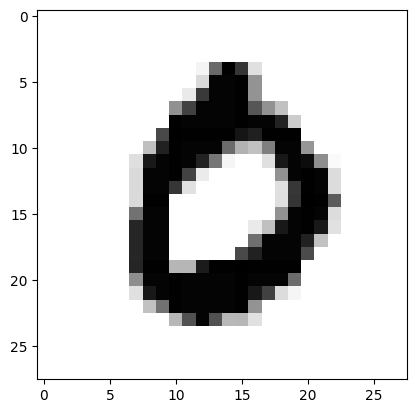

In [64]:
# 推論
import matplotlib.pyplot as plt
test_index = 3
data = test_data[test_index][0]
plt.imshow(data.reshape((28, 28)), cmap='gray_r')

In [65]:
test_data[test_index][1]

0

In [66]:
model.eval()
with torch.no_grad():
    x = data.unsqueeze(0).to(device)
    logits = model(x)
    pred = torch.softmax(logits, 1).squeeze().cpu()

In [67]:
pred

tensor([9.9941e-01, 1.6316e-11, 7.3629e-05, 9.3245e-06, 5.2931e-08, 4.0112e-04,
        7.3956e-05, 1.5023e-05, 6.5355e-06, 8.1180e-06])

<BarContainer object of 10 artists>

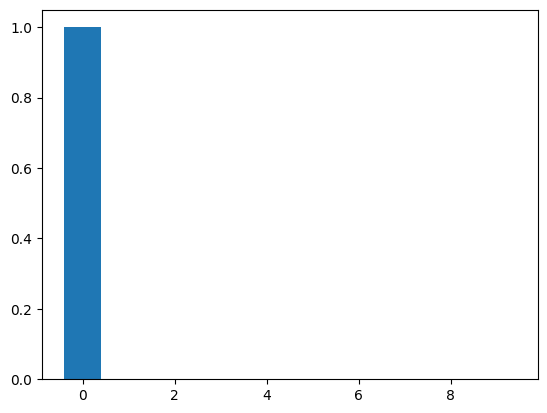

In [68]:
plt.bar(range(10), pred)